In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/home/david/work/muscles/trappist-1/hst/data/'

In [11]:
def spectra_adder(fluxes, errors):
    """
    combines the flux at each overlap
    """
    weight_f = np.average(fluxes, axis =0, weights=(1/errors**2))
    weight_e = np.average((weight_f - fluxes)**2, axis=0, weights = (1/errors**2))**0.5
    return weight_f, weight_e


In [11]:
def spec_adder(xaxis,flux_files,error_files): #takes spectra and does a weighted average, returning the weighted spectra and error
    if len(flux_files) > 1:
        weight_flux=np.zeros(len(xaxis))
        weight_error=np.zeros(len(xaxis)) #array to hold the error on the weighed average
        for e in range(len(xaxis)):
            points=flux_files[:,e]
            epoints=error_files[:,e]#creates a list of the values from each image at the same point
            points, epoints=points[(points>0.)], epoints[(points>0.)]
            plotdata=np.ma.average(points,weights=(1./epoints**2))
            if np.isnan(plotdata)==True:
                  plotdata=0.0
            if len(epoints)>1.:
                  weighterr=(np.ma.average((points-plotdata)**2.,weights=(1./epoints**2)))**(1./2.)
            elif len(epoints)==1:
                  weighterr=epoints[0]
            else:
                weighterr=0.0
            if np.isnan(weighterr)==True:
                  weighterr=0.0
            weight_flux[e]=plotdata
            weight_error[e]=weighterr
    else:
        weight_flux=flux_files[0]
        weight_error=error_files[0]
    return weight_flux,weight_error

Looking at Kevin France's extractions.

In [12]:
from scipy.io.idl import readsav
kpath = '/home/david/work/muscles/trappist-1/hst/kf_extraction/'
ksp = os.listdir(kpath)

In [13]:
from astropy.convolution import convolve, Box1DKernel

In [14]:
c_ii = [1334.532 ,1335.708]
n_v = [1238.821,1242.804]

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/david/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:388: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


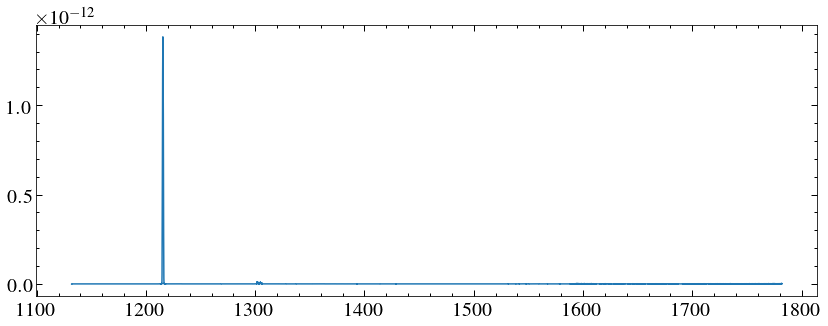

In [15]:

sp2_start = readsav(kpath+ksp[1])['Wave'][0]
sp1_end = readsav(kpath+ksp[0])['Wave'][-1]
final_flux = np.array([], dtype=float)
final_wave = np.array([], dtype=float)
final_error = np.array([], dtype=float)
sp1 = readsav(kpath+ksp[0])
final_flux = np.concatenate((final_flux, sp1['Flux'][sp1['Wave']<sp2_start]))
final_wave = np.concatenate((final_wave, sp1['Wave'][sp1['Wave']<sp2_start]))
final_error = np.concatenate((final_error, sp1['Err'][sp1['Wave']<sp2_start]))

f1_overlap = sp1['Flux'][sp1['Wave']>sp2_start]
w1_overlap = sp1['Wave'][sp1['Wave']>sp2_start]
e1_overlap = sp1['Err'][sp1['Wave']>sp2_start]
sp2 = readsav(kpath+ksp[1])
f2_overlap = sp2['Flux'][sp2['Wave']<sp1_end]
w2_overlap = sp2['Wave'][sp2['Wave']<sp1_end]
e2_overlap = sp2['Err'][sp2['Wave']<sp1_end]

overlap_w = w1_overlap
f2 = interp1d(w2_overlap, f2_overlap, fill_value='extrapolate')(overlap_w)
e2 = interp1d(w2_overlap, e2_overlap, fill_value='extrapolate')(overlap_w)
fluxes = np.array([f1_overlap, f2])
errors = np.array([e1_overlap, e2])
overlap_f, overlap_e = spectra_adder(fluxes, errors)

final_flux = np.concatenate((final_flux, overlap_f))
final_wave = np.concatenate((final_wave, overlap_w))
final_error = np.concatenate((final_error, overlap_e))

final_flux = np.concatenate((final_flux, sp2['Flux'][sp2['Wave']>sp1_end]))
final_wave = np.concatenate((final_wave, sp2['Wave'][sp2['Wave']>sp1_end]))
final_error = np.concatenate((final_error, sp2['Err'][sp2['Wave']>sp1_end]))


plt.plot(final_wave, final_flux)



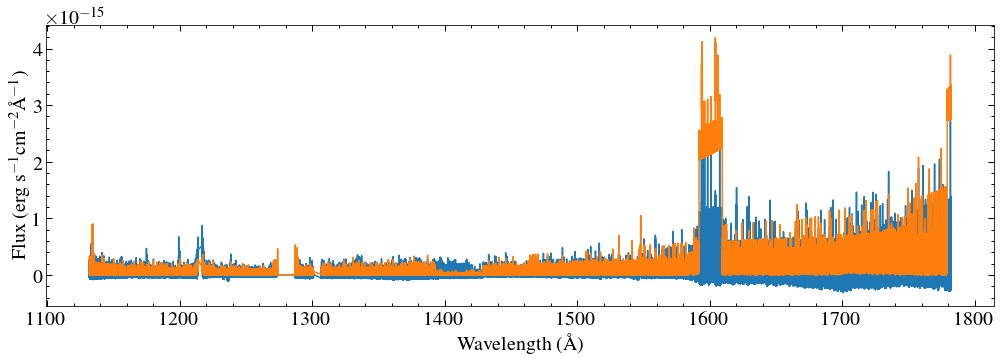

In [16]:
w, f, e = final_wave, final_flux, final_error

plt.figure()
plt.subplots_adjust(top=0.93, right = 0.99, wspace =0.05, left = 0.05, bottom=0.15)
mask = (w < 1214) | (w>1217) & (w < 1301) | (w>1307)
w, f, e = w[mask], f[mask], e[mask]
#f= convolve(f,Box1DKernel(5))
plt.plot(w,f)
plt.xlabel('Wavelength (\AA)', size=20)
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
plt.plot(w,e)

#plt.savefig('cos_fuv_eg.pdf', dpi=150)
cfw = w
cff = f
cfe = e

What about the nuv?

In [12]:
cosnuvs = []
x1ds = glob.glob(path+'*x1dsum.fits')
for sp in x1ds:
    hdr = fits.getheader(sp,0)
    if hdr['INSTRUME'] == 'COS' and hdr['DETECTOR']=='NUV':
        cosnuvs.append(sp)
cosnuvs

['/home/david/work/muscles/trappist-1/hst/data/ldlm42010_x1dsum.fits']

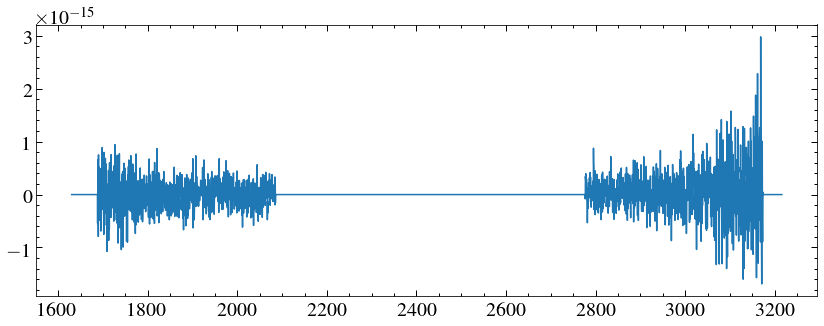

In [13]:
nuvsp= cosnuvs[0]
cnw = np.array([], dtype=float)
cnf = np.array([], dtype=float)
for dt in fits.getdata(nuvsp,1)[0:2]:
    #plt.plot(dt['WAVELENGTH'], dt['FLUX'])
    #plt.plot(dt['WAVELENGTH'], dt['ERROR'])
    cnw= np.concatenate((cnw, dt['WAVELENGTH']))
    cnf = np.concatenate((cnf, dt['FLUX'])) 
    #plt.plot(dt['WAVELENGTH'][dt['DQ']==0], dt['FLUX'][dt['DQ']==0])
    #plt.plot(dt['WAVELENGTH'][dt['DQ']==0], dt['ERROR'][dt['DQ']==0])
plt.plot(cnw, cnf)

In [19]:
x1ds = glob.glob(path+'*x1d.fits')
stisx1ds = []
for sp in x1ds:
    hdr = fits.getheader(sp,0)
    if hdr['INSTRUME'] == 'STIS':
        stisx1ds.append(sp)
stisx1ds

['/home/david/work/muscles/trappist-1/hst/data/odlm41050_x1d.fits',
 '/home/david/work/muscles/trappist-1/hst/data/odlm41040_x1d.fits',
 '/home/david/work/muscles/trappist-1/hst/data/odlm41020_recal_x1d.fits',
 '/home/david/work/muscles/trappist-1/hst/data/odlm41030_x1d.fits']

/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/david/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:388: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


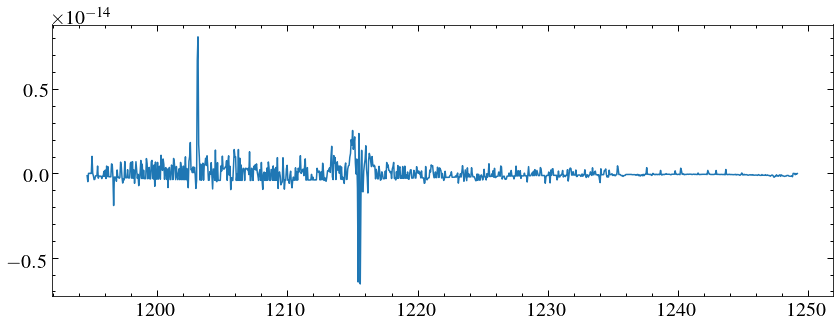

In [20]:
fluxes = []
errors = []
for sp in stisx1ds:
    data = fits.getdata(sp,1)
    dt = data[0]
    if sp == stisx1ds[0]:
        wav = dt['WAVELENGTH']#[dt['DQ']==0]   
        f = dt['FLUX']#[dt['DQ']==0]
        e = dt['ERROR']#[dt['DQ']==0]
    else:
        wi, fi = dt['WAVELENGTH'], dt['FLUX']
        f = interp1d(wi,   fi,    bounds_error=False, fill_value=0.)(wav)
        wi, ei = dt['WAVELENGTH'], dt['ERROR']
        e = interp1d(wi,   ei,    bounds_error=False, fill_value=0.)(wav)
    fluxes.append(f)
    errors.append(e)
fluxes = np.array(fluxes)
errors = np.array(errors)
flux, error = spectra_adder(fluxes, errors)
plt.plot(wav, flux)
sfw, sff = wav, flux

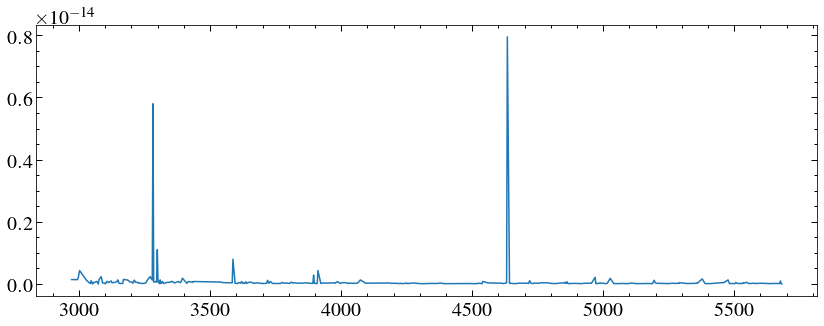

In [23]:
stis_opt = path + 'odlm41010_sx1.fits'
data = fits.getdata(stis_opt,1)
dt = data[0]
sow = dt['WAVELENGTH'][dt['DQ']==0]
sof = dt['FLUX'][dt['DQ']==0]
plt.plot(sow, sof)

In [29]:
plt.step(cfw, cff)
plt.step(cnw, cnf)
plt.step(sfw, sff)
plt.step(sow, sof)
mdt = Table.read('../optical/scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
mw, mf = mdt['WAVELENGTH'], mdt['FLUX']
plt.step(mw[(mw>sow[-1])], mf[(mw>sow[-1])])
plt.xscale('log')
plt.yscale('log')

NameError: name 'cfw' is not defined

What do we have. No continumm, so no point scaling? -except the CCD, that clearly needs doing. Unless we have overlaping lines? Also, should the NUV have that gap? Need to have a better look at the STIS Lya data. Nothing of interest in the region of overlap betwen the two COS spectra and the error on the redwards one goes way up - better to just cut the redwards one rather than coadd.

Need to look at dq for the idl files, I don't think Kevin makes a combined dq.

In [33]:
sp1 = readsav(kpath+ksp[0])
print(sp1['dqin'].shape)
print(len(sp1['wave']))


(10, 16384)
29790


Ah yes, because there are two different wavelengths.

In [38]:
[print(w[0]) for w in sp1['wavein']]

1277.8075634686027
1277.7194121098617
1277.8075954662559
1277.7467995240697
1277.8348840097633
1124.596390947617
1124.503457124606
1124.5953312052068
1124.6156472301889
1124.6775900486155


[None, None, None, None, None, None, None, None, None, None]

In [52]:
filler = np.zeros(len(sp1['wave'])-len(sp1['dqin'][0]), dtype=int)
dq_com = []
for dq, w in zip(np.array(sp1['dqin']), sp1['wavein']):
    if w[0] > 1200:
        dq_com.append(np.concatenate((filler, dq)))
    else:
        dq_com.append(np.concatenate((dq,filler)))
#print(dq_com)
dq_sum = np.max(dq_com, axis=0)
print(dq_sum)
print(dq_sum.shape)

[ 128  128  128 ... 8320 8320 8320]
(29790,)


what about the other one...

In [53]:
sp1 = readsav(kpath+ksp[1])
print(sp1['dqin'].shape)
print(len(sp1['wave']))


(6, 16384)
31808


In [54]:
[print(w[0]) for w in sp1['wavein']]

1562.6753854714366
1597.4838258528412
1597.4585487753448
1374.4187600324306
1409.205394403215
1409.13615527556


[None, None, None, None, None, None]

Ah. Ok this approach doesn't work with more than two cenwaves. Hmm... ask Kevin about it in Colorado.

In [55]:
astis = Table.read('../STIS/archival_TRAPPIST-1_G140M_mean.ecsv')

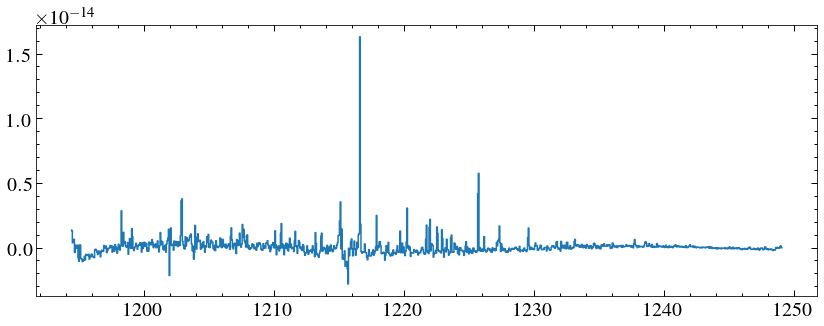

In [56]:
plt.step(astis['WAVELENGTH'], astis['FLUX'])

Nuv and G160M overlap, need to decide which one to use.

(1680, 1780)

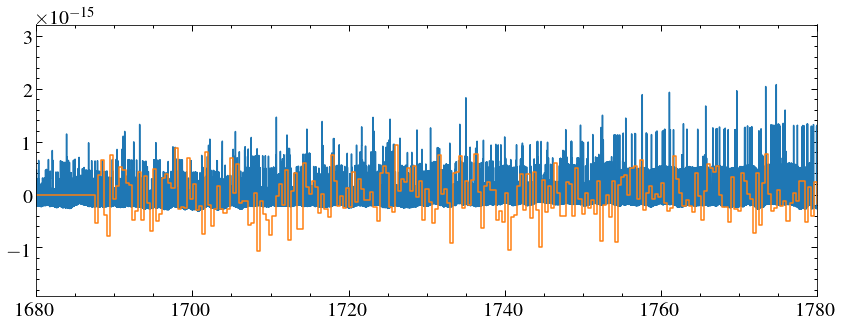

In [58]:
plt.step(cfw, cff)
plt.step(cnw, cnf)
plt.xlim(1680, 1780)

Both are basically noise, keep the FUV as a. higher resolution and b. sets an "all else being equal" standard.

Taking another look at the Oi airglow, is there a way to keep some of it?

(1300, 1310)

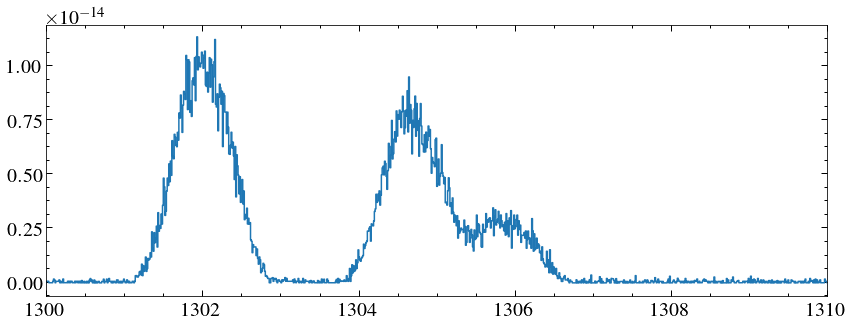

In [5]:
data = readsav('../COS/TRAPPIST1_G130M_Mm1_NOSCL_10dec2018.sav')
glowmask = (data['Wave'] <1207)|(data['Wave'] >1225)#&(data['Wave'] <1301)|(data['Wave'] >1307.)&(data['Wave'] <1355)|(data['Wave'] >1356)
plt.step(data['wave'][glowmask], data['flux'][glowmask])
plt.xlim(1300, 1310)

Nope, wiped out entirely.

NUV.

In [14]:
hdul = fits.open(nuvsp)

In [15]:
hdul.info()

Filename: /home/david/work/muscles/trappist-1/hst/data/ldlm42010_x1dsum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     166   ()      
  1  SCI           1 BinTableHDU    253   3R x 13C   [4A, 1D, 1J, 1274D, 1274E, 1274E, 1274E, 1274E, 1274E, 1274E, 1274I, 1274E, 1274E]   


In [16]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    1 / Number of standard extensions                  
DATE    = '2018-05-12'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'ldlm42010_x1dsum.fits' / name of file                                
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000.0 / equinox of celestial coord. system             
                            

In [17]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                53524 / length of dimension 1                          
NAXIS2  =                    3 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   13 / number of table fields                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ldlm42yrq                         ' / rootname of the observation set
EXPNAME = 'ldlm42yrq        

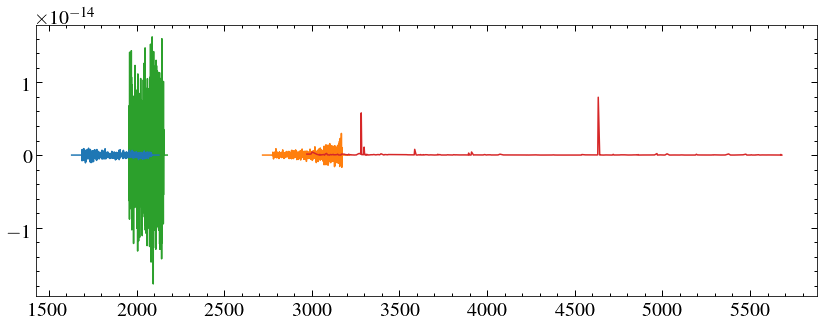

In [24]:
data = hdul[1].data
for dt in data[0:2]:
    plt.plot(dt['WAVELENGTH'], dt['FLUX'])
    #plt.plot(dt['WAVELENGTH'], dt['ERROR'])
plt.plot(data[2]['WAVELENGTH'], data[2]['FLUX'], zorder=-2)
plt.plot(sow, sof)

Is that a feature in green at 2100ish? Plotting in ipython to check... no. Looks like we can safety discard the 3rd order. But are there any interesting features in the gap? Look at P+19 models to check. Doing it in cos_v+phoenix as already set up there. Hmm...mixed results. Mybe better to keep the optical - what's that at 3000?

(-1e-15, 1e-15)

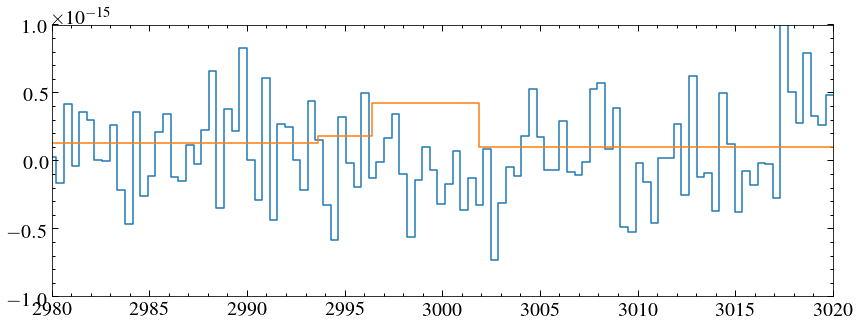

In [28]:
data = hdul[1].data
#for dt in data[0:2]:
    #plt.plot(dt['WAVELENGTH'], dt['FLUX'])
    #plt.plot(dt['WAVELENGTH'], dt['ERROR'])
plt.step(data[1]['WAVELENGTH'], data[1]['FLUX'], zorder=-2)
plt.step(sow, sof)
plt.xlim(2980, 3020)
plt.ylim(-0.1e-14, 0.1e-14)


What does our phoenix model look like in the gap?

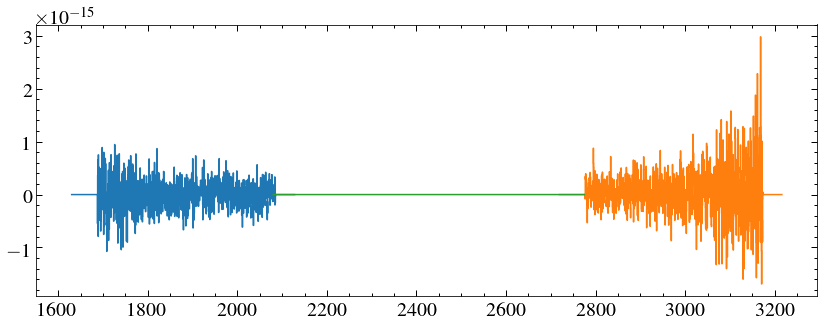

In [31]:
mdt = Table.read('../optical/scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
mw, mf = mdt['WAVELENGTH'], mdt['FLUX']

data = hdul[1].data
for dt in data[0:2]:
    plt.step(dt['WAVELENGTH'], dt['FLUX'])
mask = (mw > 2080) & (mw < 2775)
plt.step(mw[mask], mf[mask])

Lets do that. Adding to trappist_combine 20190416. Maybe not - much lower than predicted flux. Add it to the Colorado list!

In [1]:
mdt = Table.read('../optical/scaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
mw, mf = mdt['WAVELENGTH'], mdt['FLUX']

NameError: name 'Table' is not defined

In [37]:
stis_opt = 'odlm41010_sx1.fits'
#data = fits.getdata(stis_opt,1)
data = fits.getdata(stis_opt,1)[0]
#dt = data[0]
sow = data['WAVELENGTH']#[dt['DQ']==0]
sof = data['FLUX']#[dt['DQ']==0]
#sow = sow[sof>0]
#sof = sof[sof>0]

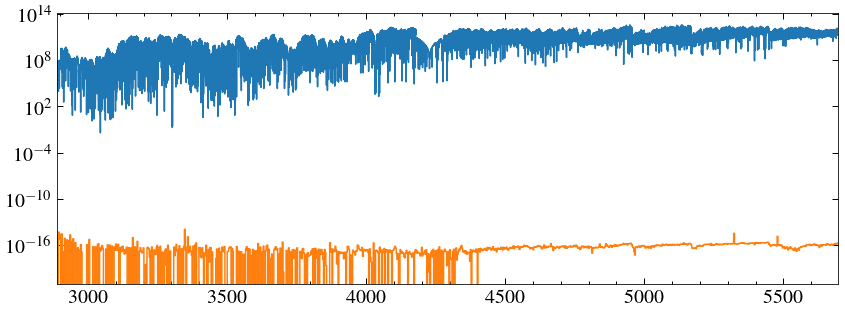

In [10]:
#plt.figure(figsize=(20, 10))
plt.step(mw[(mw > sow[0])&(mw<sow[-1])], mf[(mw > sow[0])&(mw<sow[-1])])
plt.step(sow, sof)
plt.xlim(sow[0], sow[-1])
plt.yscale('log')
#plt.ylim(-0.1e-14, 1e-14)

Scaling - scale phoenix to G430m data.

In [11]:
mdt = Table.read('../optical/unscaled_02560-5.00-0.0_phoenix_trappist-1.ecsv')
mw, mf = mdt['WAVELENGTH'], mdt['FLUX']

Current scaling from photometry is 4.71774681e-28.

In [12]:
scale_cut = 4500 #ccd spectrum bad at bluer wavelengths
so_int = np.trapz(sof[sow>scale_cut], sow[sow>scale_cut])
m_mask = (mw > scale_cut) & (mw < sow[-1])
m_int = np.trapz(mf[m_mask], mw[m_mask])

scale1 = so_int/m_int
print(scale1)

2.792529323492606e-28


better, didn't cut off the red end of the model first time...

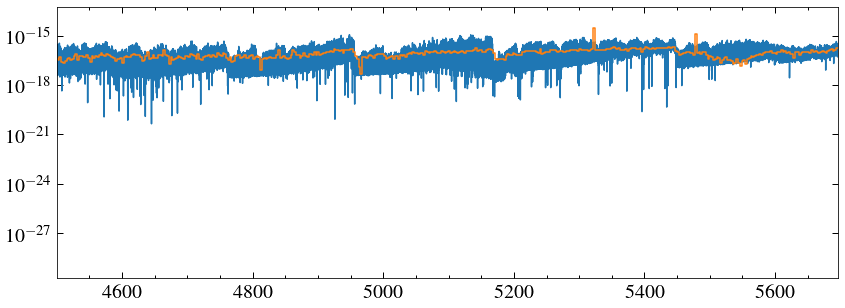

In [13]:
#plt.figure(figsize=(20, 10))
plt.step(mw[(mw > sow[0])&(mw<sow[-1])], mf[(mw > sow[0])&(mw<sow[-1])]*scale1)
plt.step(sow, sof)
plt.xlim(4500, sow[-1])
plt.yscale('log')
#plt.ylim(-0.1e-14, 1e-14)

Good. what if we interpolate onto the stis wavelength scale?

In [15]:
from craftroom import resample

In [16]:
mw1, mf1  = mw[m_mask], mf[m_mask]
w1, f1 = sow[sow>scale_cut], sof[sow>scale_cut]

In [17]:
mw2, mf2 = resample.bintogrid(mw1, mf1, newx=w1)

In [18]:
scale2 = np.trapz(f1, w1)/np.trapz(mf2, mw2)
print(scale2)
print(scale1/scale2)

2.795159077348712e-28
0.9990591756020553


Ok within .1 percent, don't think I need to worry about that too much...

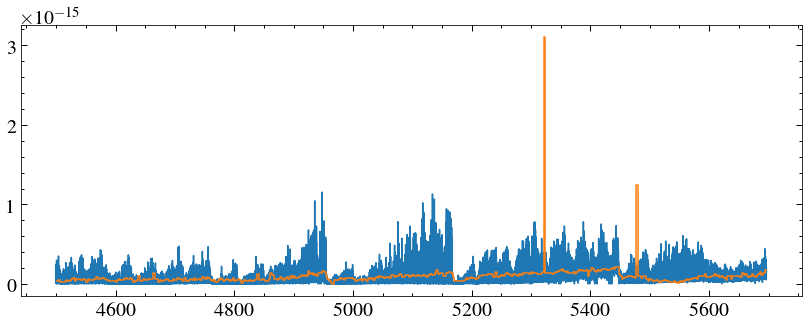

In [19]:
plt.step(mw1,mf1*scale2)
plt.step(w1, f1)

How does that compare to photometry? Checking in trappist-1 scaling notebook. Reasonable! This will solve messing about with photometry.

In [20]:
scale_cut, sow[-1]

(4500, 5696.381658058151)

What is Bourrier's lya value? F at 1au given in 1st paper.

In [21]:
f1au = 0.05
eup = 0.01
edown = 0.02

In [22]:
distance =  12.1
distance_conversion = ((1*u.au.to(u.m))/(distance*u.pc.to(u.m)))**2

In [32]:
f_obs = f1au*distance_conversion
f_obs

8.026921159574549e-15

In [31]:
eobsup = (eup/f1au)*f_obs
eobsdown = (edown/f1au)*f_obs
eobsup, eobsdown

(1.6053842319149097e-15, 3.2107684638298193e-15)

So 8e-15? Way higher than in their figure, must be doing something wrong? Nope, figure is normalised weirdly.

Ok, what are those two emmison lines in the optical? Last thing to answer before I make some nice line plots...

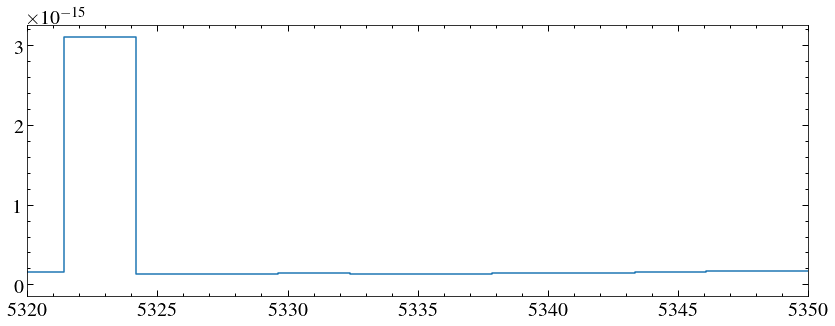

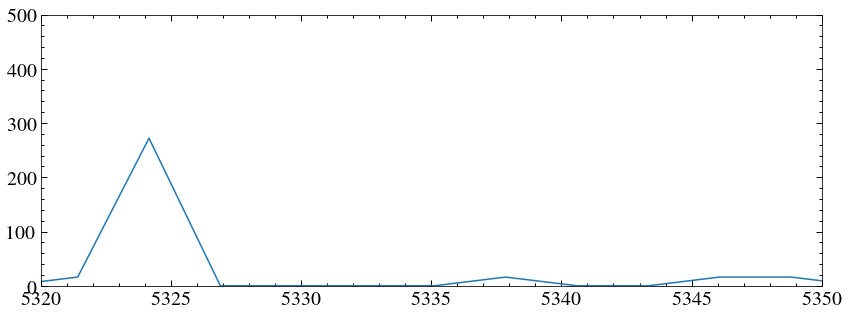

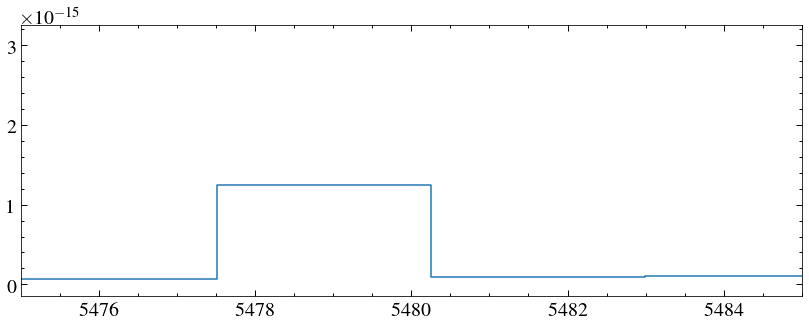

(-1, 1000)

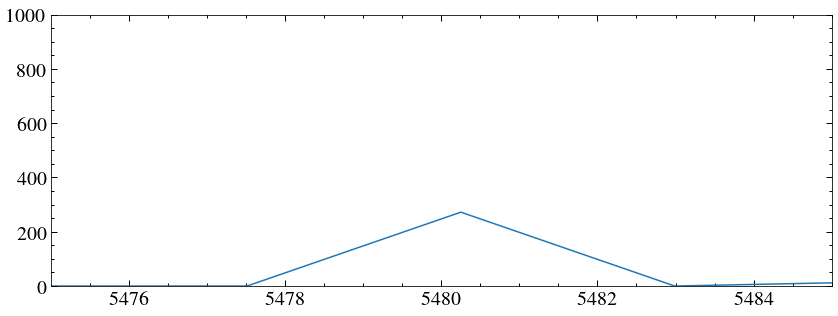

In [45]:
plt.step(w1, f1)
plt.xlim(5320, 5350)
plt.show()
plt.plot(data['WAVELENGTH'], data['DQ'])
plt.xlim(5320, 5350)
plt.ylim(-1, 500)
plt.show()

plt.step(w1, f1)
plt.xlim(5475, 5485)
plt.show()
plt.plot(data['WAVELENGTH'], data['DQ'])
plt.xlim(5475, 5485)

plt.ylim(-1, 1000)

Same dq flag = 256
Saturated pixel, count rate at 90% of max possible—local non-linearity turns over and is multi-valued; pixels within 10% of turnover and all pixels within 4 pixels of that pixel are flagged.  
Could still be real though? Compare with other spectra? Not in gj176, I'm guessing noise/cosmics.

Filling in the gap in NUV spectrum.

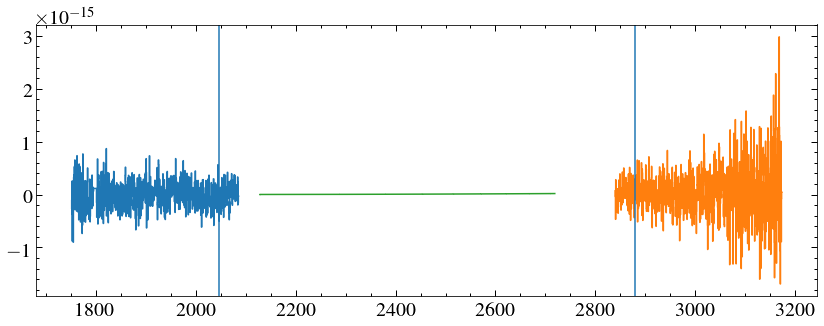

In [71]:
nuvpath = '../COS/ldlm42010_x1dsum.fits'
end = 100
data = fits.getdata(nuvpath,1)
w1, f1, dq1 = data[0]['WAVELENGTH'], data[0]['FLUX'], data[0]['DQ']
w2, f2, dq2 = data[1]['WAVELENGTH'], data[1]['FLUX'], data[1]['DQ']
plt.step(w1[dq1==0], f1[dq1==0], w2[dq2==0], f2[dq2==0])
plt.axvline(w1[dq1==0][-end])
plt.axvline(w2[dq2==0][end])

fill_w = np.arange(w1[-1],w2[0], 1.0)
end_w, end_f = np.concatenate((w1[dq1==0],w2[dq2==0])), np.concatenate((f1[dq1==0],f2[dq2==0]))
#end_w, end_f = np.concatenate((w1[dq1==0][-end:],w2[dq2==0][0:end])), np.concatenate((f1[dq1==0][-end:],f2[dq2==0][0:end]))

fill_f = np.polyval((np.polyfit(end_w,end_f,2)), fill_w)
plt.step(fill_w, fill_f)

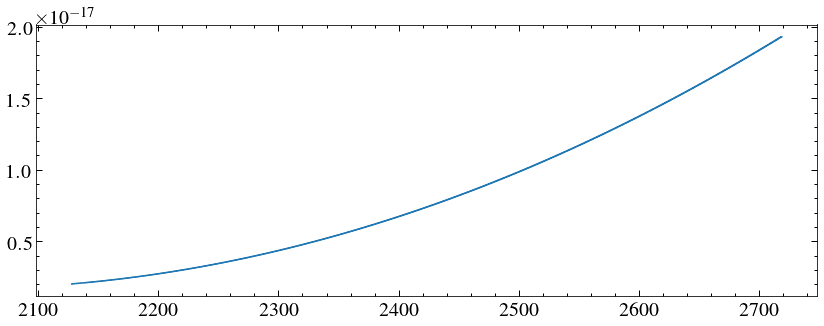

In [72]:
plt.step(fill_w, fill_f)

In [17]:
dv = -56300 #Bourrier+17a 
c = const.c.value
dshift = (1.0+(dv/c))


lya = 1215.67
lya_obs = lya*dshift
print(lya_obs)

1215.441701324788


In [24]:
b = lya_obs*(1.0+(-100e3/c))-lya_obs
r = lya_obs*(1.0+(100e3/c))-lya_obs
print(b,r)
fwhm = 2*(np.mean([abs(b),r]))
print(fwhm)

-0.4054277113684748 0.40542771136870215
0.8108554227371769


In [25]:
sigma = fwhm/2.355
I = 8e-15
a = I/(sigma*(2*np.pi)**0.5)
a

9.269312817063298e-15

In [35]:
lya_edges = [1207, 1225]
x = np.arange(lya_edges[0],lya_edges[1]+1, 0.01)

In [36]:
from astropy.modeling import models, fitting

In [39]:
fake_lya1 = models.Gaussian1D(a, lya_obs, sigma)

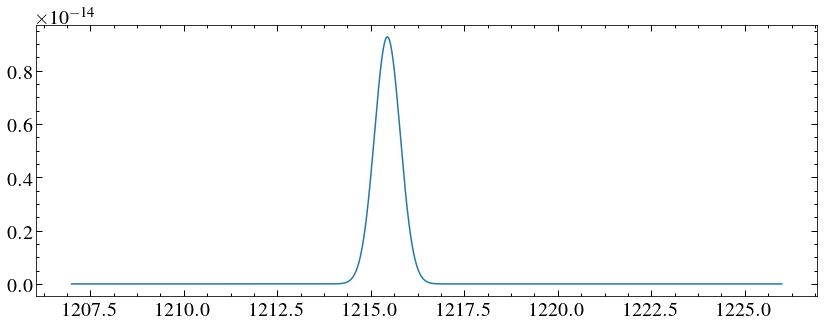

In [40]:
plt.plot(x, fake_lya1(x))

B+ plot has a = 1.3e-14, let's go from there instead.

In [41]:
a = 1.3e-14
sigma = I/(a*(2*np.pi)**0.5)
fake_lya2 = models.Gaussian1D(a, lya_obs, sigma)

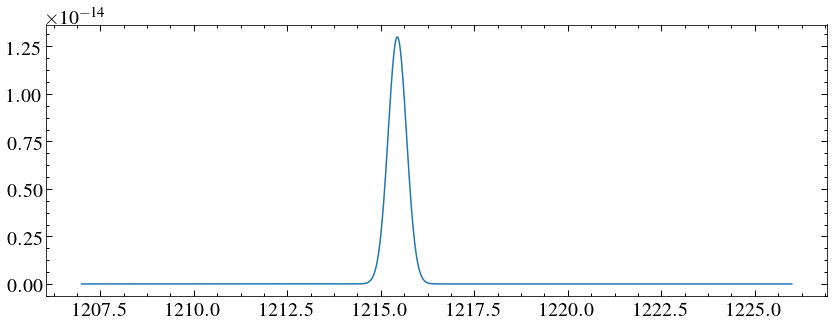

In [42]:
plt.plot(x, fake_lya2(x))

In [53]:
#convert to v
#x1 = x[(x>1214)&(x<1217)] 
xv = c*(1.-(x/lya_obs))

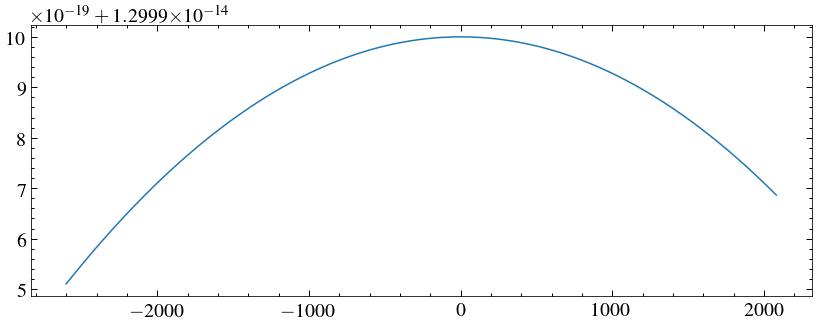

In [54]:
fake_lya3 = models.Gaussian1D(a, 0, (c*(1.-(sigma/lya_obs)))/1000)
plt.plot(xv/1000, fake_lya3(xv/1000))

That didn't work-- but the profle looks ok? How does it compare to the gj 674 one?

In [55]:
lya_674 = Table.read('../../gj_674/lya/GJ674_intrinsic_LyA_profile.txt', format='ascii')

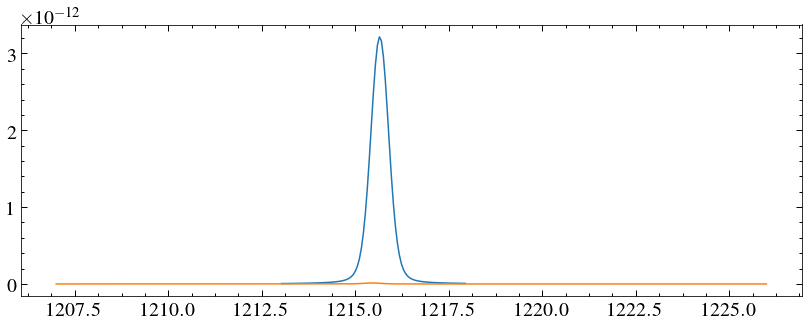

In [57]:
plt.plot(lya_674['WAVELENGTH'], lya_674['FLUX'])
plt.plot(x, fake_lya2(x))

In [60]:
print(np.mean(np.diff(lya_674['WAVELENGTH'])))
w1, f1 = lya_674['WAVELENGTH'],lya_674['FLUX']


0.05335646667013496


In [61]:
w2 = np.arange(w1[0], w1[-1]+0.05, 0.05)

In [62]:
f2 = fake_lya2(w2)

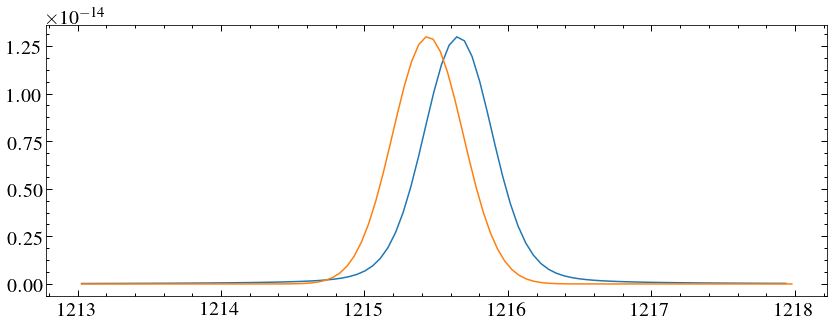

In [65]:
plt.plot(w1, f1*(max(f2)/max(f1)))
plt.plot(w2, f2)

Yay they look the same!

In [73]:
#np.savetxt('bourrier_lya.txt', [w2, f2])
data = Table((w2, f2), names=('WAVELENGTH', 'FLUX'))
ascii.write(data, 'bourrier_lya.txt', overwrite=True)

In [5]:
fdt = Table.read('trappist-1_sed_var_res_blya.ecsv')

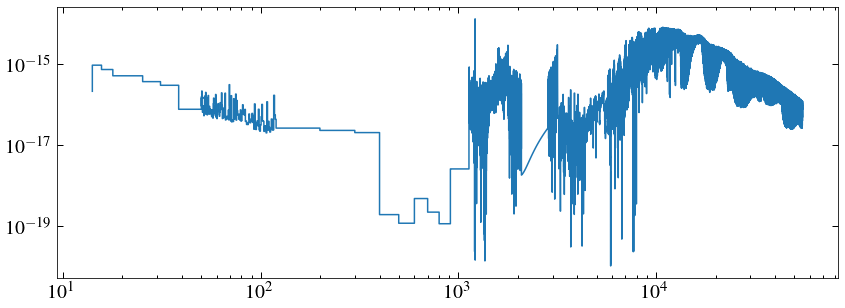

In [6]:
w, f = fdt['WAVELENGTH'], fdt['FLUX']
mask = f > 1e-20
plt.step(w[mask], f[mask])
plt.xscale('log')
plt.yscale('log')

Well that looks awful

Bolometric flux fitting. Could we fit to the STIS optical data rather than the PHOENIX model?

In [82]:
stis_opt = 'odlm41010_sx1.fits'
#data = fits.getdata(stis_opt,1)
data = fits.getdata(stis_opt,1)[0]
#dt = data[0]
w = data['WAVELENGTH']#[dt['DQ']==0]
f = data['FLUX']#[dt['DQ']==0]
#sow = sow[sof>0]
#sof = sof[sof>0]

In [96]:
mask = (w > 4500) & (w < 5321) | (w > 5325) & (w < 5476.5) | (w > 5480.5) #cutting out overlap and cosmics
wo, fo = w[mask], f[mask]


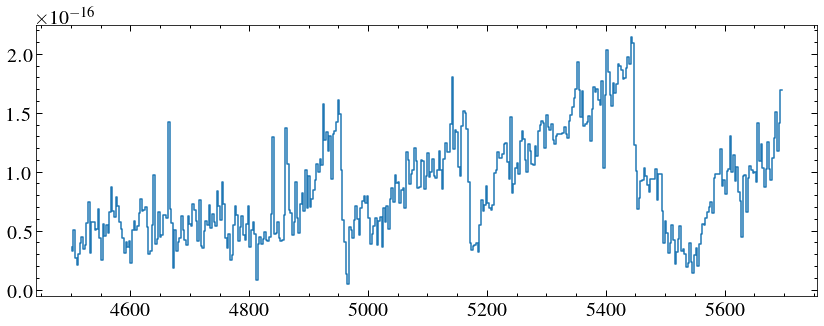

In [84]:
plt.step(w,f)

In [85]:
from astropy.modeling.models import BlackBody1D
from astropy.modeling.blackbody import FLAM

In [86]:
teff = 2560*u.K

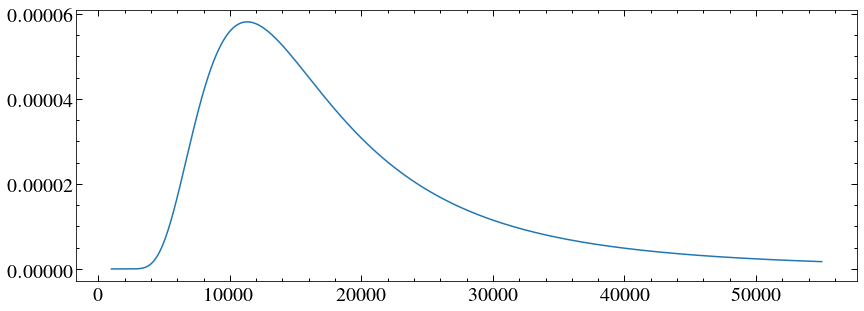

In [95]:
bb = BlackBody1D(temperature=teff)
diff = np.mean(np.diff(w))
wav = np.arange(1000, 5.5e4, diff) *u.AA
flux = bb(wav).to(FLAM, u.spectral_density(wav))
wbb, fbb =wav.value, flux.value
plt.plot(wav, flux)

In [9]:
wa, fa = fdt['WAVELENGTH'], fdt['FLUX']

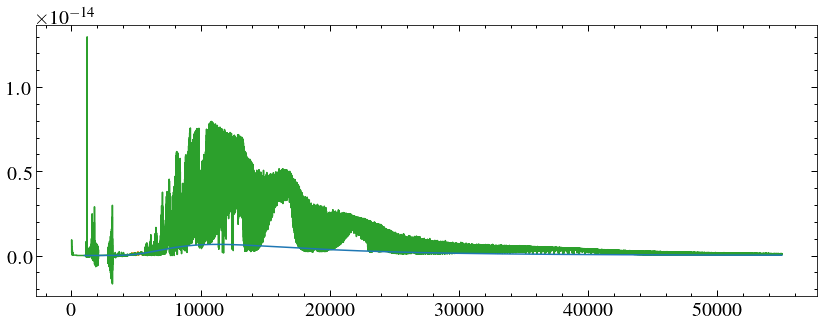

In [103]:
mask = (wbb >= wo[0]) & (wbb <= wo[-1])
int_opt = np.trapz(fo, wo)
int_bb = np.trapz(fbb[mask], wbb[mask])
scale = int_opt/int_bb
plt.plot(wbb, fbb*scale)
plt.step(wo, fo, zorder=-1)
plt.step(wa, fa, zorder=-1)
#plt.xlim(4000, 6000)

Well that didn't work.

6.819936534192487e-12 0.12065877796577341
5.652250627075852e-11


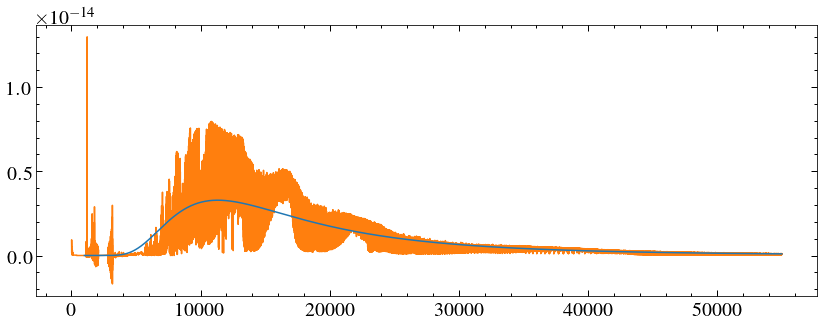

In [124]:
rj = 30000.
m1 = (wa>rj)
int_spec = np.trapz(fa[m1], wa[m1])
m2 = (wbb>rj) & (wbb <=wa[-1])
int_bb = np.trapz(fbb[m2], wbb[m2])
print(int_spec, int_bb)
scale = int_spec/int_bb
print(scale)
plt.plot(wbb, fbb*scale)
plt.step(wa, fa, zorder=-1)

So its the intergral of the bb from 55000 to infintiy, scaled by the scale factor?

In [125]:
#oom
np.trapz(fa, wa)

6.679565821088475e-11

Does the spectrum look nicer on the 1A scale?

In [10]:
from craftroom import resample


In [11]:
wi, fi = resample.bintogrid(wa, fa,  dx=1.0)

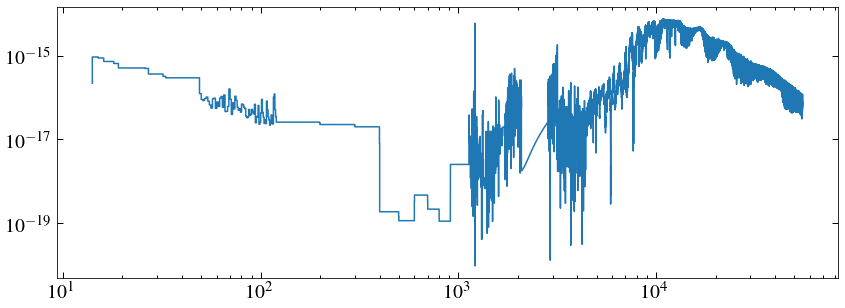

In [12]:
plt.step(wi[fi>0], fi[fi>0])
plt.xscale('log')
plt.yscale('log')

A bit.

In [4]:
dt_674 = Table.read('../../gj_674/combined/gj_674_sed_var_res_v2.ecsv')

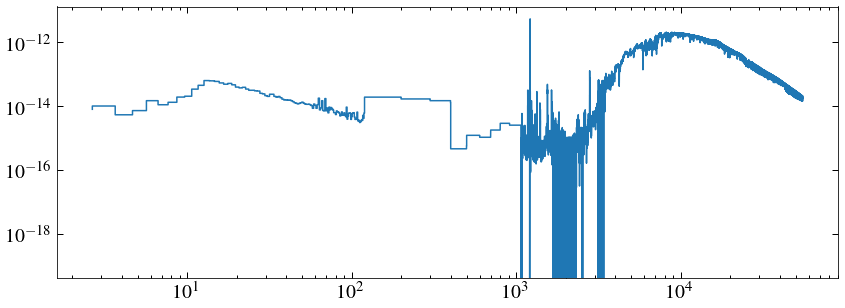

In [13]:
w674, f674 = dt_674['WAVELENGTH'], dt_674['FLUX']
w674i, f674i = resample.bintogrid(w674, f674,  dx=1.0)
plt.step(w674i, f674i)
plt.xscale('log')
plt.yscale('log')

In [14]:
d_t1 = 12.1
d_674 = 4.54
t1_scale = ((1*u.au.to(u.m))/(d_t1*u.pc.to(u.m)))**2
gj_scale = ((1*u.au.to(u.m))/(d_674*u.pc.to(u.m)))**2

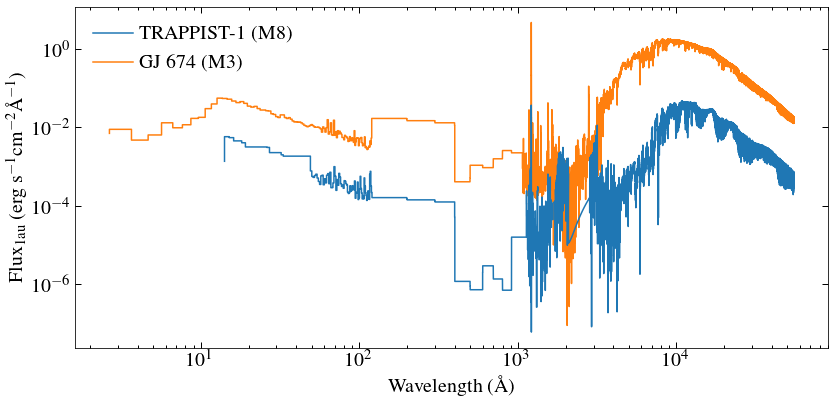

In [32]:
plt.figure(figsize=(12,6))
plt.step(wi[fi>0], fi[fi>0]/t1_scale, label ='TRAPPIST-1 (M8)')
plt.step(w674i[f674i>0], f674i[f674i>0]/gj_scale, zorder=-1, label = 'GJ 674 (M3)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux$_{1\mathrm{au}}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
plt.savefig('../plots/Trappist1_GJ674_1AU.pdf', dpi=150)
plt.savefig('../plots/Trappist1_GJ674_1AU.png', dpi=150)

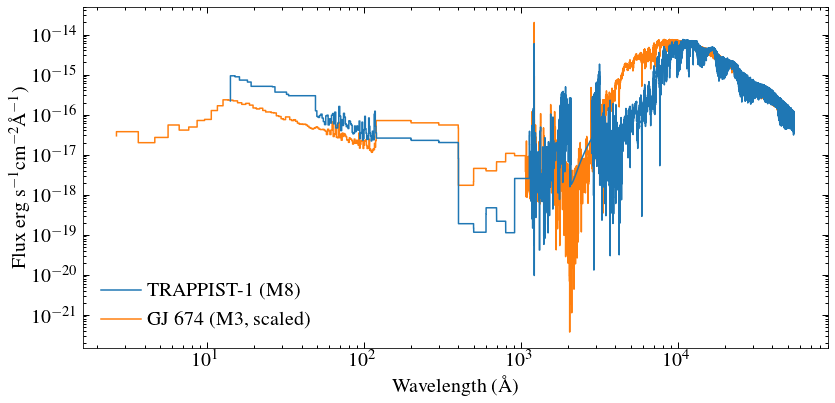

In [33]:
plt.figure(figsize=(12,6))
peak_scale = np.max(f674i [w674i > 3000])/np.max(fi [wi > 3000])
plt.step(wi[fi>0], fi[fi>0],label ='TRAPPIST-1 (M8)')
plt.step(w674i[f674i>0], f674i[f674i>0]/peak_scale, zorder=-1, label = 'GJ 674 (M3, scaled)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/Trappist1_GJ674_scaled.pdf', dpi=150)
plt.savefig('../plots/Trappist1_GJ674_scaled.png', dpi=150)

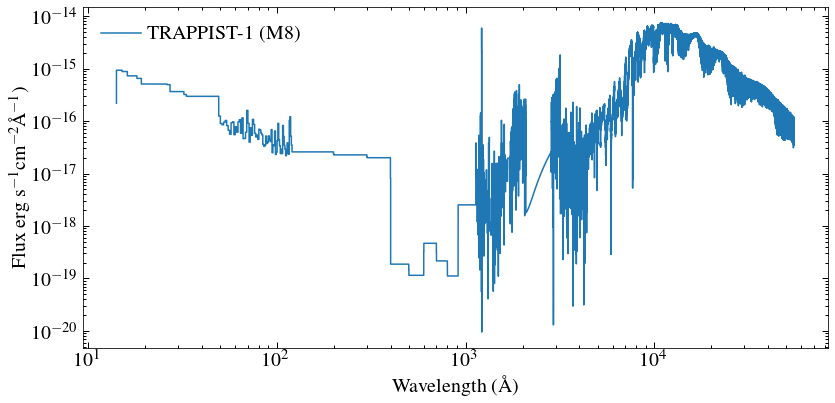

In [37]:
plt.figure(figsize=(12,6))
peak_scale = np.max(f674i [w674i > 3000])/np.max(fi [wi > 3000])
plt.step(wi[fi>0], fi[fi>0],label ='TRAPPIST-1 (M8)')
#plt.step(w674i[f674i>0], f674i[f674i>0]/peak_scale, zorder=-1, label = 'GJ 674 (M3, scaled)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/Trappist1_sed.pdf', dpi=150)
plt.savefig('../plots/Trappist1_sed.png', dpi=150)

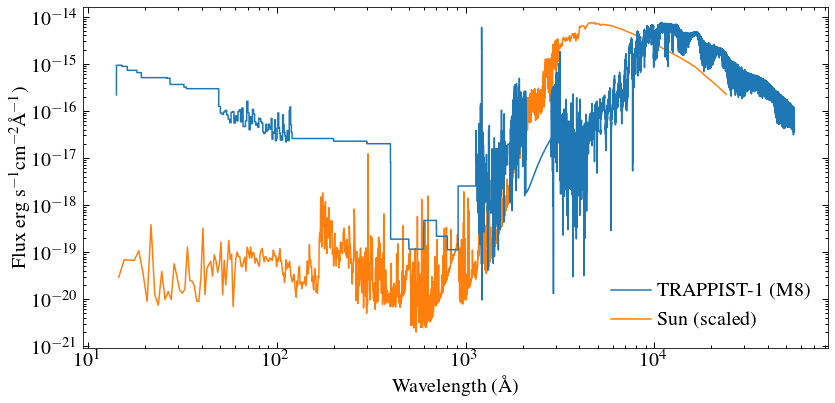

In [38]:
plt.figure(figsize=(12,6))

plt.step(wi[fi>0], fi[fi>0],label ='TRAPPIST-1 (M8)')

#add the solar spectrum
sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
sw = sol_spec['wave']*10
sf = sol_spec['flux']*100
scale2 = max(fi[wi>3000])/max(sf)
mask = (sw > wi[0])
#plt.plot(sw, sf*scale2, 'k--', label='Sun (scaled)' , alpha=0.5)
plt.plot(sw[mask], (sf[mask])*scale2, label='Sun (scaled)' , zorder=-1)

#plt.errorbar((3,60),(1e-11, 1e-11), yerr= [[5e-12,5e-12],[0,0]], c ='k')
#plt.annotate('XMM', (11, 2e-11))

#plt.errorbar((60,100),(1e-11, 1e-11), yerr= [[5e-12,5e-12],[0,0]], c ='k')
#plt.annotate('APEC', (60, 2e-11))

#plt.errorbar((100,1060),(1e-11, 1e-11), yerr= [[5e-12,5e-12],[0,0]], c ='k')
#plt.annotate('EUV Estimate', (140, 2e-11))

#plt.errorbar((1068, 5692),(1e-11, 1e-11), yerr= [[5e-12,5e-12],[0,0]], c ='k')
#plt.annotate('HST', (2000, 2e-11))

#plt.errorbar((5692, 54963),(1e-11, 1e-11), yerr= [[0,5e-12],[0,0]], c ='k')
#plt.annotate('PHOENIX', (11000, 2e-11))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/Trappist1_Sun.pdf', dpi=150)
plt.savefig('../plots/Trappist1_Sun.png', dpi=150)


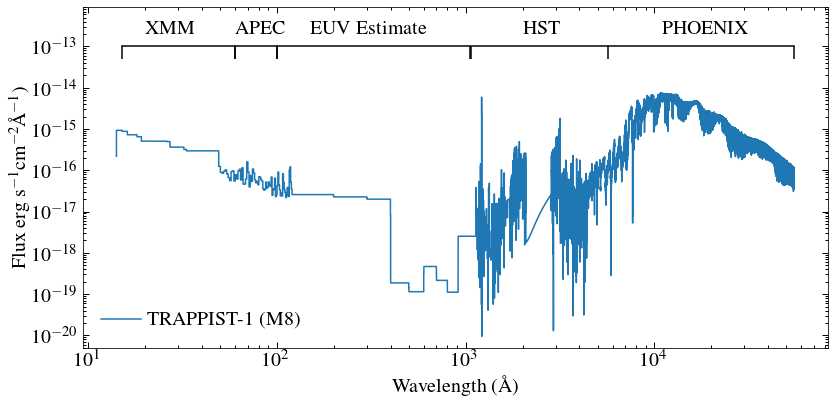

In [49]:
plt.figure(figsize=(12,6))
plt.step(wi[fi>0], fi[fi>0],label ='TRAPPIST-1 (M8)')

plt.errorbar((15,60),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('XMM', (20, 2e-13))

plt.errorbar((60,100),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('APEC', (60, 2e-13))

plt.errorbar((100,1060),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('EUV Estimate', (150, 2e-13))

plt.errorbar((1068, 5692),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('HST', (2000, 2e-13))

plt.errorbar((5692, 54963),(1e-13, 1e-13), yerr= [[0,5e-14],[0,0]], c ='k')
plt.annotate('PHOENIX', (11000, 2e-13))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.legend()
plt.ylim(5.1e-21, 9e-13)
plt.tight_layout()
plt.savefig('../plots/Trappist1_labels.pdf', dpi=150)
plt.savefig('../plots/Trappist1_labels.png', dpi=150)